# Notes

**Important**

This notebook was created on *April 23, 2024, at 19:08*  with the intention of providing detailed explanations and interpretations of the processes involved. While Python scripts are powerful, they can sometimes be complex and require a significant investment in terms of analysis and understanding. This document aims to simplify this task by breaking down and explaining each code segment in detail.

In this notebook, we will undertake to revisit and detail the implementations of the MNIST dataset, a dataset widely used in the machine learning community, initially popularized by Yann LeCun. The goal is to implement two types of neural architectures: a Multi-Layer Perceptron (MLP) and a Convolutional Neural Network (CNN). We will then compare their performances through various metrics.

Additionally, special attention will be given to visualizing backpropagation to identify the global optimum. This approach aims to illustrate not only how modifications to the weights affect model accuracy during training but also to demonstrate optimization dynamics in action.

This work is essential for those looking to deepen their understanding of deep learning fundamentals as well as for those wishing to refine their ability to optimize machine learning algorithms.

## Setup

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## PyTorch
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

In [18]:
# Load data
train_data = torchvision.datasets.MNIST(root='data', train=True,
                                        download=True, transform=torchvision.transforms.ToTensor())

test_data = torchvision.datasets.MNIST(root='data', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor()
)

print('Data are ready!')

Data are ready!


We have downloaded the data, now to extract the images and labels we will type the following command:

```bash
X = train_data.data
y = train_data.targets
```

In [19]:
# Examples
# Images are in uint8
print(f'The label ==> {train_data.targets[0]}')
train_data.data[0]

The label ==> 5


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

## Preparation

We are going to prepare the images here. The images are already in an appropriate format and require no special preparation other than normalization. As you may notice, the pixel values range from 0 to 255. This range can increase the computational load and introduce significant variance. Therefore, it is crucial to normalize the data. Using a MinMaxScaler normalization could be beneficial to scale our data from 0 to 1.

The MinMax normalization formula is given by: $MinMax = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$.

Next, we will load these normalized data into a DataLoader, which will compact our data and organize it into batches. This will enable us to use the GPU for computations, making the process more efficient.

In [20]:
# Store the data
# Print dimension of the data
print(f'train_data ==> {train_data.data.shape}')
print(f'test_data ==> {test_data.data.shape}')

train_data ==> torch.Size([60000, 28, 28])
test_data ==> torch.Size([10000, 28, 28])


In [21]:
def plot_images_grid_from_dataset(dataset, num_images=25, title=None):
    """
    Plots a grid of images with labels directly from the dataset.

    Args:
    dataset (torch.utils.data.Dataset): Dataset from which to load the data.
    num_images (int): Number of images to display in the grid.
    title (str): Title of the plot.
    """
    if len(dataset) < num_images:
        raise ValueError("The dataset contains fewer images than the number requested for display.")
    
    # Manually fetch a batch of images and labels
    images = []
    labels = []
    for i in range(num_images):
        image, label = dataset[i]
        images.append(image)
        labels.append(label)
    
    # Convert lists to tensor
    images = torch.stack(images)
    labels = torch.tensor(labels)

    # Create a grid of images
    img_grid = torchvision.utils.make_grid(images, normalize=True, scale_each=True)

    # Show images
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0), cmap='gray', vmin=0, vmax=1)  # Rearrange the order of channels
    plt.axis('off')
    
    # Adding the title
    if title:
        plt.title(title)

    # Show labels in the title or a legend (optional)
    labels_str = ', '.join(map(str, labels.tolist()))
    plt.xlabel(f"Labels: {labels_str}")

    plt.show()

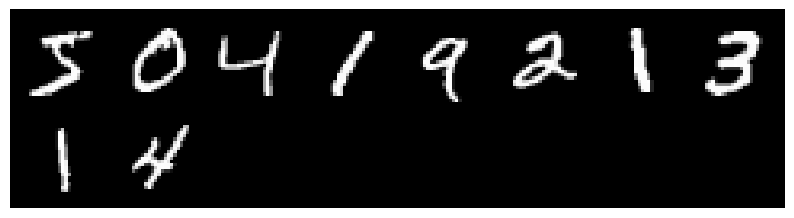

In [22]:
plot_images_grid_from_dataset(train_data, num_images=10)

These results indicate that our dataset contains 60,000 images, each with a height and width of 28 pixels. The structure of these data in a three-dimensional tensor (observations, height, width) also reveals that the images are in black and white, using a single channel. For color images, the tensor structure would include a fourth dimension corresponding to the color channels.

Let's move on to normalization:
The pixel values range from 0 to 255. Since the minimum value 
𝑋_min
X_min is zero, we can simplify the normalization by merely dividing each pixel by 255. This operation scales the pixel values to the range [0, 1], which is often required to optimize the performance of machine learning algorithms.

In [23]:
# Normalization
train_data.data = train_data.data / 255.0
test_data.data = test_data.data / 255.0

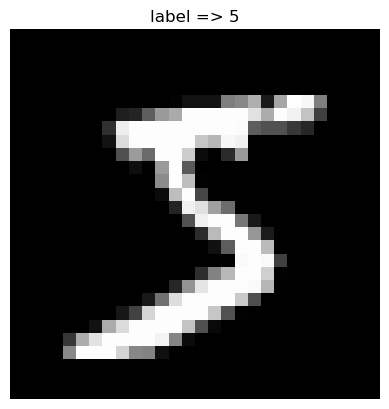

In [24]:
plt.title(f'label => {train_data.targets[0].numpy()}')
plt.axis('off')
plt.imshow(train_data.data[0], cmap='gray')

In [25]:
# Injection
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

## Modeling

In [26]:
# Choose the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In this section, we will explore the design and implementation of neural network models, which are essentially assemblies of functions $f(x)$ working together to solve complex problems through the aggregation of their predictions. The origins of neural networks date back to the 1960s with the introduction of the perceptron by Frank Rosenblatt. This model is described by the equation $y = W \cdot X + b$, where $W$ represents the weights, $X$ the inputs, and $b$ the bias. However, despite this innovation, the perceptron was limited to solving linear problems due to its fundamental structure.

The advent of the 1980s and 1990s saw significant advancements in this field thanks to the work of Geoffrey Hinton and others, who developed the MultiLayer Perceptron (MLP). The MLP is a network composed of multiple layers of perceptrons, enabling it to capture complex nonlinearities and handle problems well beyond the capabilities of the simple perceptron. This enhanced ability makes the MLP particularly effective for a variety of applications ranging from image recognition to predictive modeling in financial and medical domains.

We will now proceed to the practical implementation of an MLP. This model, structured in successive layers of neurons with nonlinear activations, allows for modeling complex relationships between inputs and desired outputs. Achieving this objective involves a deep understanding of the underlying principles of tensor calculus, gradients, and backpropagation—crucial elements for the effective training of neural networks.

This exploration is set within a context of ongoing research where neural network models are constantly refined to improve their accuracy, efficiency, and applicability to an increasingly broad array of complex challenges across various scientific and engineering fields. Thus, the development of MLPs is not just a technical task but also a quest to extend the boundaries of what machines can learn to do from data.

In [27]:
def Trainer(dataloader, validloader, model, criterion, optimizer, epochs=15):
    """
    This function allows you to train a model using training data sets (dataloader) while evaluating its performance on validation data.
    Using tqdm (taqadum) provides a visual progress bar to track training and assessment progress.
    A separate progress bar is used for each training epoch, showing progress across training batches, as well as a separate progress bar for evaluation on validation data.
    ---
    We return two lists, loss_cache and valid_cache, which respectively contain the average training losses for each epoch and the evaluation results on the validation data,
    such as average loss and accuracy.
    """
    size = len(dataloader)
    model = model.to(device)
    model.train()
    loss_cache = []
    valid_cache = []
    acc = []
    loss_test = []
    training_time = []

    for i in range(epochs):
      total_loss = 0
      start_time = time.time()

      for batch, (X, y) in enumerate(tqdm(dataloader, desc='Progress')):
        # compute prediction and loss
        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = criterion(preds, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

      # Time calcul
      end_time = time.time()
      train_time = end_time - start_time
      training_time.append(train_time)

      # Calculate loss
      avg_loss = total_loss / size
      loss_cache.append(avg_loss)
      print(f"\nEpoch [{i + 1}/{epochs}] - Avg Training Loss: {avg_loss:.6f}")

      # Evaluation on validation set
      model.eval()
      total_correct = 0
      total_test_loss = 0

      with torch.no_grad():
        for X_val, y_val in validloader:
          X_val = X_val.to(device)
          y_val = y_val.to(device)
          preds_val = model(X_val)
          total_test_loss += criterion(preds_val, y_val).item()
          total_correct += (preds_val.argmax(1) == y_val).type(torch.float).sum().item()


      avg_test_loss = total_test_loss / len(validloader)
      accuracy = total_correct / len(validloader.dataset)
      acc.append(accuracy)
      loss_test.append(avg_test_loss)
      valid_cache.append({"test_loss": loss_test, "accuracy": acc})

      # Print loss and accuracy for the valid loader
      print(f"Validation - Avg Loss: {avg_test_loss:.6f} | Accuracy: {accuracy * 100:.2f}%\n")

    # Time for the training
    total_time = sum(training_time)
    print("Total training time for {} epochs: {:.2f} seconds".format(epochs, total_time))

    return loss_cache, valid_cache


def predict_mnist(model, img, label):
  """
  Prediction 
  """
  model.eval()
  img_tensor = torch.tensor(img, dtype = torch.float32)
  img_tensor = img_tensor.unsqueeze(0)
  with torch.no_grad():
    img_tensor = img_tensor.to(device)
    preds = model(img_tensor)
    probabilities = torch.softmax(preds, dim=1)
    top_probabilities, top_labels = torch.topk(probabilities, 2)

  top_probabilities = top_probabilities[0].cpu().numpy()
  top_labels = top_labels[0].cpu().numpy()

  color_title = 'green' if label == top_labels[0] else 'red'

  title_text = (f'Predicted: {top_labels[0]} => Probability: {top_probabilities[0] * 100:.2f}%, \n'
              f'Second Predicted: {top_labels[1]} => Probability: {top_probabilities[1] * 100:.2f}%')


  plt.title(title_text, color=color_title)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()


<img src="img/Perceptron.drawio.png" alt="perceptron" width="50%" height="50%">


In [28]:
# Perform a Perceptron
class Perceptron(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Perceptron, self).__init__()
        # Ensure the input dimension is correctly provided
        self.y = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # Here is to Flatten the Data, we will explain after
        x = self.y(x)
        x = F.log_softmax(x, dim=1)
        return x

The `x.view` method is crucial for preparing input data for neural networks, particularly when images are processed by perceptrons that only understand data in vector form. This function resizes tensors without altering the underlying data, allowing the transformation of an image, typically represented by a matrix or 3D tensor, into a one-dimensional vector.

Applying `x.view(self.input_size.size(0), 1)` reshapes the tensor to fit the network's input dimensions, converting all image features into a single linear vector. This vectorization is essential because it enables the perceptron to process each image pixel as part of a linear sequence of numerical values, thus facilitating classification based on global features rather than the spatial structure of the image.

In [29]:
# Assuming input dimensions for MNIST (28x28 images)
input_dim = 28 * 28
num_classes = 10
#parameters
lr = 2e-4

# Define hyperparameters
criterion = nn.CrossEntropyLoss()

In [30]:
perceptron = Perceptron(input_dim, num_classes)
print(perceptron)

Perceptron(
  (y): Linear(in_features=784, out_features=10, bias=True)
)


In [31]:
optimizer = optim.Adam(perceptron.parameters(), lr = lr)

In [32]:
loss_cache, valid_cache = Trainer(train_loader, test_loader, perceptron, criterion, optimizer)

Progress: 100%|██████████| 3750/3750 [00:05<00:00, 691.97it/s]



Epoch [1/15] - Avg Training Loss: 1.769511
Validation - Avg Loss: 1.619709 | Accuracy: 50.53%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 631.82it/s]



Epoch [2/15] - Avg Training Loss: 1.584620
Validation - Avg Loss: 1.549970 | Accuracy: 51.25%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 655.72it/s]



Epoch [3/15] - Avg Training Loss: 1.532165
Validation - Avg Loss: 1.514172 | Accuracy: 52.04%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 696.90it/s]



Epoch [4/15] - Avg Training Loss: 1.501456
Validation - Avg Loss: 1.492098 | Accuracy: 52.46%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 690.06it/s]



Epoch [5/15] - Avg Training Loss: 1.481212
Validation - Avg Loss: 1.476794 | Accuracy: 52.44%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 627.66it/s]



Epoch [6/15] - Avg Training Loss: 1.467736
Validation - Avg Loss: 1.467707 | Accuracy: 52.93%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 734.49it/s]



Epoch [7/15] - Avg Training Loss: 1.457733
Validation - Avg Loss: 1.459834 | Accuracy: 53.18%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 639.06it/s]



Epoch [8/15] - Avg Training Loss: 1.450180
Validation - Avg Loss: 1.454495 | Accuracy: 53.00%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 732.23it/s]



Epoch [9/15] - Avg Training Loss: 1.444289
Validation - Avg Loss: 1.450102 | Accuracy: 53.43%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 670.06it/s]



Epoch [10/15] - Avg Training Loss: 1.439391
Validation - Avg Loss: 1.446269 | Accuracy: 53.73%



Progress: 100%|██████████| 3750/3750 [00:06<00:00, 617.47it/s]



Epoch [11/15] - Avg Training Loss: 1.435480
Validation - Avg Loss: 1.443325 | Accuracy: 53.67%



Progress: 100%|██████████| 3750/3750 [00:06<00:00, 610.81it/s]



Epoch [12/15] - Avg Training Loss: 1.432049
Validation - Avg Loss: 1.441981 | Accuracy: 53.86%



Progress: 100%|██████████| 3750/3750 [00:06<00:00, 589.05it/s]



Epoch [13/15] - Avg Training Loss: 1.429319
Validation - Avg Loss: 1.438058 | Accuracy: 53.84%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 711.69it/s]



Epoch [14/15] - Avg Training Loss: 1.426849
Validation - Avg Loss: 1.437834 | Accuracy: 53.63%



Progress: 100%|██████████| 3750/3750 [00:05<00:00, 690.19it/s]



Epoch [15/15] - Avg Training Loss: 1.424761
Validation - Avg Loss: 1.435183 | Accuracy: 54.07%

Total training time for 15 epochs: 84.86 seconds


/tmp/ipykernel_59882/2718096395.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img, dtype = torch.float32)


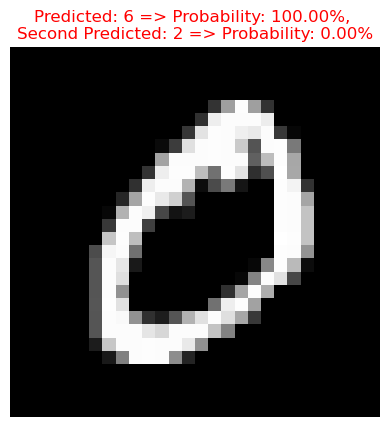

In [33]:
predict_mnist(perceptron, train_data.data[1], train_data.targets[1])

It is crucial to understand the limitations of machine learning models, particularly in the context of the simple perceptron, which is often used for linearly separable problems. The perceptron, being a linear classifier, finds its limits in environments where the data are not linearly separable.

### Analysis of the Perceptron's Limitations

The simple perceptron makes its predictions based on a linear decision function of the form $f(x) = w \cdot x + b$, where $(w)$ represents the weights, $(x)$ the inputs, and $(b)$ the bias. In cases where the data cannot be separated by a single straight line (or hyperplane in higher-dimensional spaces), the perceptron fails to converge to a solution.

For example, consider an image with dimensions width × height × channels. This structure of multivariable and high-dimensionality data exceeds the capabilities of the simple perceptron. In reality, each pixel in the image could influence the classification label in a nonlinear manner, which is beyond the reach for a model that can only use a linear decision boundary.

In [37]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1) 
        return x 

In [38]:
multilayer = MLP(input_dim, num_classes) # MLP is also called DNN for Dense Neural Network or ANN Artificail Neural Network
print(multilayer)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [39]:
optimizer_mlp = optim.Adam(multilayer.parameters(), lr = lr)
loss_cache_mlp, valid_cache_mlp = Trainer(train_loader, test_loader, multilayer, criterion, optimizer_mlp)

Progress: 100%|██████████| 3750/3750 [00:10<00:00, 359.71it/s]



Epoch [1/15] - Avg Training Loss: 1.279880
Validation - Avg Loss: 1.140570 | Accuracy: 60.40%



Progress: 100%|██████████| 3750/3750 [00:11<00:00, 336.12it/s]



Epoch [2/15] - Avg Training Loss: 1.130100
Validation - Avg Loss: 1.104089 | Accuracy: 61.70%



Progress: 100%|██████████| 3750/3750 [00:12<00:00, 309.09it/s]



Epoch [3/15] - Avg Training Loss: 1.098874
Validation - Avg Loss: 1.102668 | Accuracy: 61.21%



Progress: 100%|██████████| 3750/3750 [00:15<00:00, 237.49it/s]



Epoch [4/15] - Avg Training Loss: 1.080362
Validation - Avg Loss: 1.088346 | Accuracy: 61.77%



Progress: 100%|██████████| 3750/3750 [00:14<00:00, 263.43it/s]



Epoch [5/15] - Avg Training Loss: 1.065096
Validation - Avg Loss: 1.080067 | Accuracy: 61.76%



Progress: 100%|██████████| 3750/3750 [00:13<00:00, 283.97it/s]



Epoch [6/15] - Avg Training Loss: 1.052823
Validation - Avg Loss: 1.081107 | Accuracy: 61.79%



Progress: 100%|██████████| 3750/3750 [00:13<00:00, 286.98it/s]



Epoch [7/15] - Avg Training Loss: 1.043662
Validation - Avg Loss: 1.069622 | Accuracy: 62.51%



Progress: 100%|██████████| 3750/3750 [00:12<00:00, 301.90it/s]



Epoch [8/15] - Avg Training Loss: 1.034000
Validation - Avg Loss: 1.069509 | Accuracy: 62.30%



Progress: 100%|██████████| 3750/3750 [00:13<00:00, 276.55it/s]



Epoch [9/15] - Avg Training Loss: 1.025669
Validation - Avg Loss: 1.073139 | Accuracy: 62.17%



Progress: 100%|██████████| 3750/3750 [00:13<00:00, 287.18it/s]



Epoch [10/15] - Avg Training Loss: 1.016988
Validation - Avg Loss: 1.075573 | Accuracy: 62.26%



Progress: 100%|██████████| 3750/3750 [00:13<00:00, 283.32it/s]



Epoch [11/15] - Avg Training Loss: 1.009415
Validation - Avg Loss: 1.075016 | Accuracy: 62.42%



Progress: 100%|██████████| 3750/3750 [00:13<00:00, 287.19it/s]



Epoch [12/15] - Avg Training Loss: 1.001870
Validation - Avg Loss: 1.079285 | Accuracy: 62.29%



Progress: 100%|██████████| 3750/3750 [00:12<00:00, 301.43it/s]



Epoch [13/15] - Avg Training Loss: 0.993475
Validation - Avg Loss: 1.072822 | Accuracy: 62.63%



Progress: 100%|██████████| 3750/3750 [00:13<00:00, 283.08it/s]



Epoch [14/15] - Avg Training Loss: 0.985771
Validation - Avg Loss: 1.093658 | Accuracy: 62.16%



Progress: 100%|██████████| 3750/3750 [00:13<00:00, 288.13it/s]



Epoch [15/15] - Avg Training Loss: 0.978455
Validation - Avg Loss: 1.097772 | Accuracy: 61.79%

Total training time for 15 epochs: 194.07 seconds


/tmp/ipykernel_59882/2718096395.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img, dtype = torch.float32)


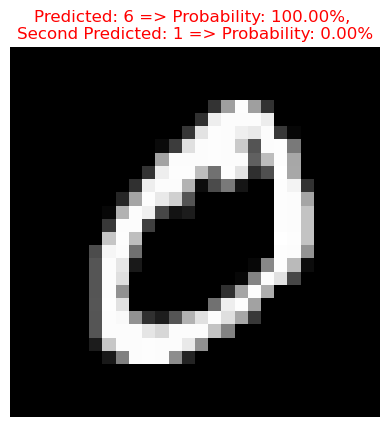

In [40]:
predict_mnist(multilayer, train_data.data[1], train_data.targets[1])

We have observed improvements with the Multi-Layer Perceptron (MLP) model, but the results remain unsatisfactory. As previously mentioned, the MLP does not inherently process images as such; it requires the transformation of images into one-dimensional vectors. This vectorization process has a significant drawback: it destroys the spatial information contained in the image, specifically the relative arrangement of pixels.

To overcome this limitation, Convolutional Neural Networks (CNNs) have been developed. These models are specifically designed to handle images as inputs, preserving and leveraging spatial information through the application of convolutional filters. CNNs are able to extract the most relevant features from images, significantly enhancing their ability to make accurate predictions.

One of the earliest CNN architectures implemented was LeNet, developed by Yann LeCun in 1986. This network was revolutionary in the field of deep learning as it introduced the concept of convolutions that effectively capture essential details and structures in images. LeNet laid the groundwork for modern CNN architectures, which are now central to many computer vision applications.

We will explore the workings and foundational principles of LeNet to understand how it captures meaningful spatial information and thus improves the quality of predictions on visual data.

In [41]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4x4 is the dimension after pooling and convolution operations
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 16*4*4)  # Flatten the tensor correctly
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [42]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [43]:
optimizer_net = optim.Adam(net.parameters(), lr = lr)
loss_cache_net, valid_cache_net = Trainer(train_loader, test_loader, net, criterion, optimizer_net)

Progress: 100%|██████████| 3750/3750 [00:14<00:00, 250.84it/s]



Epoch [1/15] - Avg Training Loss: 1.531169
Validation - Avg Loss: 1.353627 | Accuracy: 50.44%



Progress: 100%|██████████| 3750/3750 [00:14<00:00, 266.39it/s]



Epoch [2/15] - Avg Training Loss: 1.317703
Validation - Avg Loss: 1.307689 | Accuracy: 51.78%



Progress: 100%|██████████| 3750/3750 [00:15<00:00, 243.67it/s]



Epoch [3/15] - Avg Training Loss: 1.253674
Validation - Avg Loss: 1.229748 | Accuracy: 56.65%



Progress: 100%|██████████| 3750/3750 [00:15<00:00, 249.76it/s]



Epoch [4/15] - Avg Training Loss: 1.208356
Validation - Avg Loss: 1.202615 | Accuracy: 57.82%



Progress: 100%|██████████| 3750/3750 [00:16<00:00, 231.35it/s]



Epoch [5/15] - Avg Training Loss: 1.180161
Validation - Avg Loss: 1.160919 | Accuracy: 59.04%



Progress: 100%|██████████| 3750/3750 [00:13<00:00, 274.22it/s]



Epoch [6/15] - Avg Training Loss: 1.161000
Validation - Avg Loss: 1.161177 | Accuracy: 58.88%



Progress: 100%|██████████| 3750/3750 [00:14<00:00, 260.27it/s]



Epoch [7/15] - Avg Training Loss: 1.147234
Validation - Avg Loss: 1.155082 | Accuracy: 59.43%



Progress: 100%|██████████| 3750/3750 [00:14<00:00, 252.65it/s]



Epoch [8/15] - Avg Training Loss: 1.135625
Validation - Avg Loss: 1.128395 | Accuracy: 60.12%



Progress: 100%|██████████| 3750/3750 [00:16<00:00, 222.29it/s]



Epoch [9/15] - Avg Training Loss: 1.126587
Validation - Avg Loss: 1.130688 | Accuracy: 60.10%



Progress: 100%|██████████| 3750/3750 [00:16<00:00, 228.89it/s]



Epoch [10/15] - Avg Training Loss: 1.118181
Validation - Avg Loss: 1.118754 | Accuracy: 60.87%



Progress: 100%|██████████| 3750/3750 [00:18<00:00, 197.86it/s]



Epoch [11/15] - Avg Training Loss: 1.110521
Validation - Avg Loss: 1.122110 | Accuracy: 60.32%



Progress: 100%|██████████| 3750/3750 [00:15<00:00, 238.67it/s]



Epoch [12/15] - Avg Training Loss: 1.104353
Validation - Avg Loss: 1.115107 | Accuracy: 60.77%



Progress: 100%|██████████| 3750/3750 [00:16<00:00, 230.43it/s]



Epoch [13/15] - Avg Training Loss: 1.099100
Validation - Avg Loss: 1.104663 | Accuracy: 61.09%



Progress: 100%|██████████| 3750/3750 [00:16<00:00, 228.81it/s]



Epoch [14/15] - Avg Training Loss: 1.094810
Validation - Avg Loss: 1.115293 | Accuracy: 60.71%



Progress: 100%|██████████| 3750/3750 [00:16<00:00, 224.69it/s]



Epoch [15/15] - Avg Training Loss: 1.089240
Validation - Avg Loss: 1.112502 | Accuracy: 60.93%

Total training time for 15 epochs: 235.87 seconds


/tmp/ipykernel_59882/2718096395.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img, dtype = torch.float32)


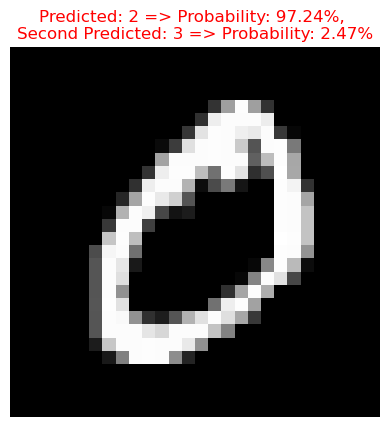

In [48]:
predict_mnist(net, train_data.data[1], train_data.targets[1])

In [ ]:
# To continue